# Load Libraries

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, ParameterGrid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Import Data

In [2]:
X_train = pd.read_csv('0_X_train.csv', index_col='Id')
X_valid = pd.read_csv('1_X_valid.csv', index_col='Id')
X_test  = pd.read_csv('2_X_test.csv', index_col='Id')

y_train = pd.read_csv('0_y_train.csv', index_col='Id')
y_valid = pd.read_csv('1_y_valid.csv', index_col='Id')
y_test  = pd.read_csv('2_y_test.csv', index_col='Id')

num_vars = ['age', 'time_spent', 'banner_views', 'banner_views_old', 'days_elapsed_old', 'X4']

X_pred = pd.read_csv("TEST_KAGGLE.csv", index_col="Id")

In [3]:
preprocessor = ColumnTransformer(transformers=
                                 [('num', StandardScaler(), num_vars)],
                                  remainder='passthrough')

np.random.seed(1)
knn_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("knn_model", KNeighborsClassifier(n_neighbors=1))
])

knn1 = knn_pipe.fit(X_train, y_train)

C:\Users\ficop\AppData\Roaming\Python\Python311\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [4]:
y_hat = knn1.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_hat, squared=False))
rmse

0.0

In [5]:
y_hat_valid = knn1.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_hat_valid, squared=False))
rmse

0.7002959704822554

In [6]:
y_hat_test = knn1.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_hat_test, squared=False))
rmse

0.6953659309317536

# Find Best K

In [7]:
folds = KFold(n_splits=10 , shuffle=True, random_state=1)

knn_best = KNeighborsClassifier()
hyper_parameters = {"n_neighbors" : np.arange(1, 50, 2)}

In [8]:
knnCV = GridSearchCV(estimator=knn_best, param_grid=hyper_parameters, scoring="neg_mean_squared_error",
                       cv=folds)
knnCV.fit(X_train, y_train)

C:\Users\ficop\AppData\Roaming\Python\Python311\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\ficop\AppData\Roaming\Python\Python311\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\ficop\AppData\Roaming\Python\Python311\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\ficop\AppData\Roaming\Python\Python311\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])},
             scoring='neg_mean_squared_error')

In [9]:
resCV = knnCV.cv_results_

test_MSEs = -resCV["mean_test_score"]
std_test_MSEs = resCV["std_test_score"] / np.sqrt(10)
k_grid = resCV["param_n_neighbors"].data

index_best = np.argmin(test_MSEs) # index of the k value with the lowest MSE estimate
best_k = k_grid[index_best]
best_k

11

In [10]:
one_std_rule_best_k = np.min(k_grid[test_MSEs <= test_MSEs[index_best] + std_test_MSEs[index_best]])
one_std_rule_best_k

5

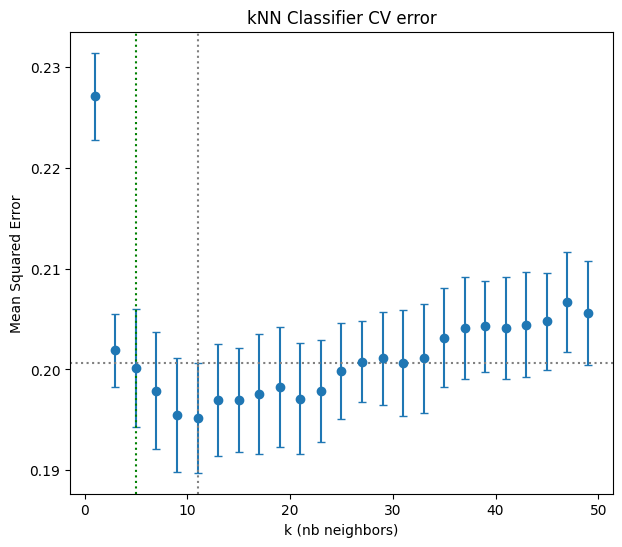

In [11]:
plt.figure(figsize=(7,6))
plt.errorbar(x=k_grid, y=test_MSEs, yerr=std_test_MSEs, fmt='o', capsize=3)

plt.axvline(best_k, ls='dotted', color="grey")#vertical line at the k yielding minimum CV MSE
plt.axvline(one_std_rule_best_k, ls='dotted', color="green")#vertical line at best k value according to 1 std err rule
plt.axhline(test_MSEs[index_best] + std_test_MSEs[index_best], ls='dotted', color="grey")

plt.title("kNN Classifier CV error")
plt.xlabel('k (nb neighbors)')
plt.ylabel('Mean Squared Error')
plt.show()

# Optimal KNN

In [12]:
knn_pipe_opt = Pipeline([
    ("preprocessor", preprocessor),
    ("knn_model", KNeighborsClassifier(n_neighbors=one_std_rule_best_k))
])
knn_opt = knn_pipe_opt.fit(X_train, y_train)

C:\Users\ficop\AppData\Roaming\Python\Python311\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [13]:
y_hat = knn_opt.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_hat, squared=False))
rmse

0.6090167240152471

In [14]:
y_hat_valid = knn_opt.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_hat_valid, squared=False))
rmse

0.6732994618513066

In [15]:
y_hat_test = knn_opt.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_hat_test, squared=False))
rmse

0.6581594661459141